In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Carga de datos

In [2]:
train_data = pd.read_csv("spaceship-titanic/train.csv")
print(train_data.shape)
train_data.head(3)

(8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [3]:
test_data = pd.read_csv("spaceship-titanic/test.csv")
test_data.shape

(4277, 13)

In [4]:
data = pd.concat([train_data, test_data], ignore_index=True)
data.shape

(12970, 14)

In [5]:
data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported      object
dtype: object

## Valores faltantes

In [6]:
data.isna().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

## Valores repetidos y únicos

In [7]:
data.nunique()

PassengerId     12970
HomePlanet          3
CryoSleep           2
Cabin            9825
Destination         3
Age                80
VIP                 2
RoomService      1578
FoodCourt        1953
ShoppingMall     1367
Spa              1679
VRDeck           1642
Name            12629
Transported         2
dtype: int64

Cada pasajero tiene un `PassengerId` único, sin embargo hay algunos nombres que se repiten. También, varios pasajeros comparten `Cabin`.

## Análisis de correlación

In [8]:
data.corr(numeric_only=True).style.background_gradient('viridis')

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Age,1.000000,0.067300,0.124447,0.034959,0.118992,0.101441
RoomService,0.067300,1.000000,-0.020146,0.057402,0.008936,-0.023847
FoodCourt,0.124447,-0.020146,1.000000,-0.001589,0.228990,0.244279
ShoppingMall,0.034959,0.057402,-0.001589,1.000000,0.010504,0.004485
Spa,0.118992,0.008936,0.228990,0.010504,1.000000,0.149874
VRDeck,0.101441,-0.023847,0.244279,0.004485,0.149874,1.000000


# Análisis univariante y multivariante

## PassengerId

A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. **People in a group are often family members, but not always.**

In [9]:
passengersInfo = data.PassengerId.apply( lambda gggg_pp : pd.Series(index=['PassengerGroup','PassengerGroupNum'],
                                                                          data=[gggg_pp.split('_')[0], gggg_pp.split('_')[1]]) )
data = data.merge(passengersInfo, how='inner', left_index=True, right_index=True)
data.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,PassengerGroupNum
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01


In [10]:
data.PassengerGroup.min(), data.PassengerGroup.max()

('0001', '9280')

In [11]:
data.PassengerGroupNum.min(), data.PassengerGroupNum.max()

('01', '08')

In [12]:
data.loc[ data.PassengerGroupNum=='08', 'PassengerGroup' ].unique()

array(['0984', '4005', '4256', '4498', '5133', '5756', '5885', '8168',
       '8728', '8796', '8956', '8988', '9081', '0339', '1072', '6332',
       '6499', '6986', '8543'], dtype=object)

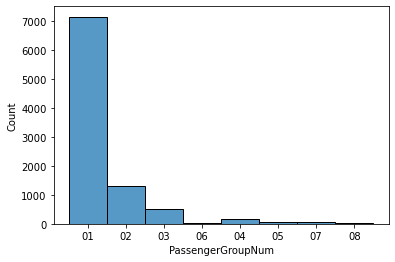

In [13]:
sns.histplot( data.groupby('PassengerGroup')['PassengerGroupNum'].max() );

Quizás se pueda extraer una variable que clasifique los grupos en función del tamaño.

In [14]:
group_size = data.groupby('PassengerGroup')[['PassengerGroupNum']].max().rename(columns={'PassengerGroupNum':'GroupSize'}).reset_index()
group_size['GroupSize'] = group_size.GroupSize.astype('int')
data = data.merge(group_size, how='left', on='PassengerGroup')

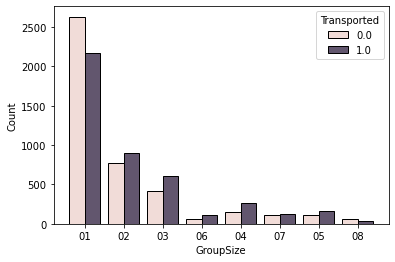

In [15]:
sns.histplot(data=data, x='GroupSize', hue='Transported', multiple='dodge', shrink=.8);

Salvo en grupos de tamaño 1 y 8, en el resto de grupos hay más pasajeros perdidos que no transportados.

## HomePlanet

The planet the passenger departed from, typically their planet of permanent residence.

In [16]:
data.HomePlanet.value_counts(dropna=False)

Earth     6865
Europa    3133
Mars      2684
NaN        288
Name: HomePlanet, dtype: int64

In [17]:
data.HomePlanet.fillna("Ns/Nc", inplace=True)

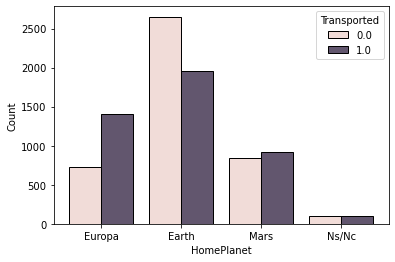

In [18]:
sns.histplot(data, x='HomePlanet', hue='Transported', multiple='dodge', shrink=.8);

Solo entre los pasajeros provenientes de la Tierra hay menos cantidad de pasajeros que se pierden.

## CryoSleep

Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

In [19]:
data.CryoSleep.value_counts(dropna=False)

False    8079
True     4581
NaN       310
Name: CryoSleep, dtype: int64

In [20]:
data['CryoSleep'] = data.CryoSleep.astype('string').fillna('Ns/Nc')

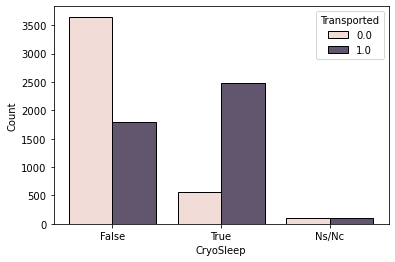

In [21]:
sns.histplot(data, x='CryoSleep', hue='Transported', multiple='dodge', shrink=.8);

En esta variable se hace mucho más obvio que los pasajeros que iban dormidos tenían muchas más posibilidades de perderse.

## Cabin

The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

In [22]:
passengersInfo = data.Cabin.apply( lambda cabin : pd.Series(index=['CabinDeck','CabinNum','CabinSide'],
                                                                  data=[cabin.split('/')[0], cabin.split('/')[1], cabin.split('/')[2]]) if pd.notna(cabin)\
                                         else pd.Series(index=['CabinDeck','CabinNum','CabinSide'], data=["Ns/Nc",np.nan,"Ns/Nc"]) )
data = data.merge(passengersInfo, how='inner', left_index=True, right_index=True)
data.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,PassengerGroupNum,GroupSize,CabinDeck,CabinNum,CabinSide
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,01,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,01,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,02,A,0,S


In [23]:
data.CabinDeck.value_counts(dropna=False)

F        4239
G        3781
E        1323
B        1141
C        1102
D         720
A         354
Ns/Nc     299
T          11
Name: CabinDeck, dtype: int64

In [24]:
data.groupby('VIP')['CabinDeck'].value_counts(dropna=False)

VIP    CabinDeck
False  F            4102
       G            3693
       E            1274
       B            1058
       C            1018
       D             666
       A             299
       Ns/Nc         281
       T              10
True   B              58
       C              55
       A              45
       D              41
       F              41
       E              26
       Ns/Nc           7
Name: CabinDeck, dtype: int64

'G' y 'T' son las únicas `CabinDeck` que no tienen pasajeros VIP. No está clara la relación entre estas 2 variables.

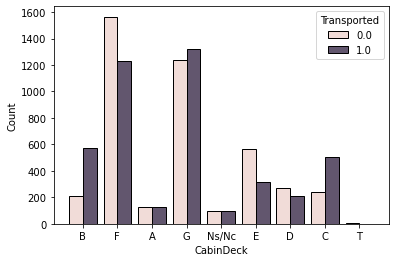

In [25]:
sns.histplot(data, x='CabinDeck', hue='Transported', multiple='dodge', shrink=.8);

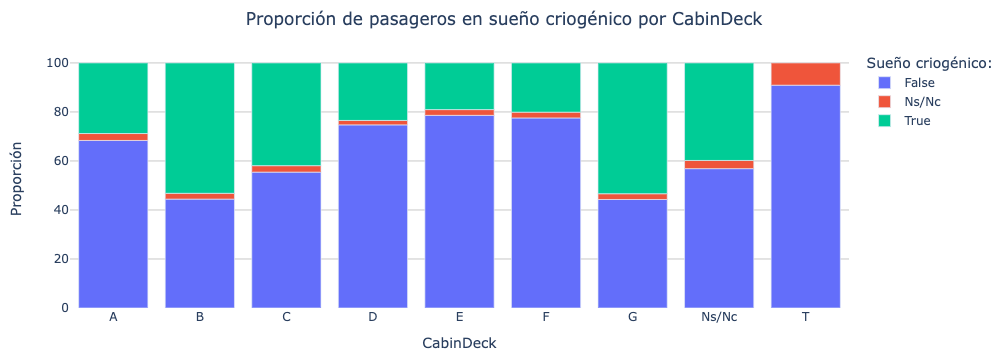

In [62]:
tmp = data.groupby(['CryoSleep','CabinDeck']).count().iloc[:,0]
tmp.name = 'Count'
df = tmp.to_frame().reset_index()
df['Núm. pasajeros'] = df.Count

fig = px.bar(df, x="CabinDeck", y="Count", color="CryoSleep", hover_data={'CabinDeck':False, 'CryoSleep':False, 'Núm. pasajeros':True}, labels={"Count": "Proporción"})
fig.update_layout(plot_bgcolor='white',
                  hovermode="closest",
                  legend={'title_text':'Sueño criogénico:'},
                  title={'text': 'Proporción de pasajeros en sueño criogénico por CabinDeck', 'x': 0.5},
                  margin={'l':70, 'r':140, 't':50, 'b':50},
                  barnorm='percent')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=True, gridwidth=1.2, gridcolor='#d1d1d1')
fig.show()

No parece haber una relación clara entre `CabinDeck` y pasajeros en sueño criogénico.

In [26]:
data.CabinSide.value_counts(dropna=False)

S        6381
P        6290
Ns/Nc     299
Name: CabinSide, dtype: int64

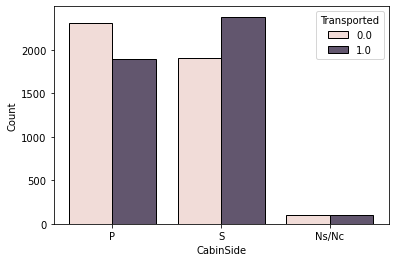

In [27]:
sns.histplot(data, x='CabinSide', hue='Transported', multiple='dodge', shrink=.8);

## Destination

The planet the passenger will be debarking to.

In [28]:
data.Destination.value_counts(dropna=False)

TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
NaN               274
Name: Destination, dtype: int64

In [29]:
data['Destination'] = data.Destination.astype('string').fillna('Ns/Nc')

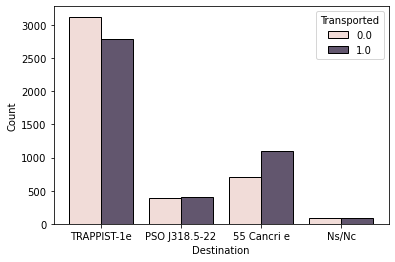

In [30]:
sns.histplot(data, x='Destination', hue='Transported', multiple='dodge', shrink=.8);

Se puede comprobar si tiene relación con `Cabin` por ejemplo.

## Age

The age of the passenger.

In [31]:
data.Age.describe()

count    12700.000000
mean        28.771969
std         14.387261
min          0.000000
25%         19.000000
50%         27.000000
75%         38.000000
max         79.000000
Name: Age, dtype: float64

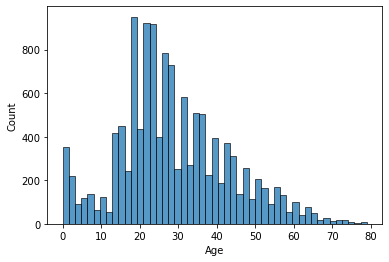

In [32]:
sns.histplot(data.Age);

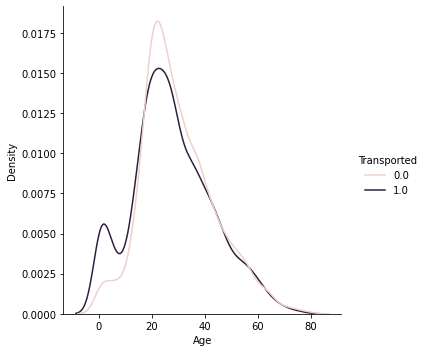

In [33]:
sns.displot(data=data, x="Age", hue="Transported", kind="kde");

Las mayores diferencias se ven en los pasajeros más jóvenes y en los que tienen 20-30 años. Entre los primeros hay un mayor porcentaje de pasajeros perdidos, mientras que en el grupo de jóvenes hay mayor proporción de pasajeros que no fueron transportados. En el resto del espectro de edades no parece haber diferencias.data.Age

Posibilidad de binarizar esta variable.

In [68]:
# bins = pd.IntervalIndex.from_tuples([(0, 20), (21, 40), (41, 60), (61, 80)], closed='both')
# bins = pd.IntervalIndex.from_tuples([(0, 15), (16, 30), (31, 45), (46, 60), (61, 75), (76, 90)], closed='both')
# 'labels' no funciona con IntervalBins.
data['AgeBinarized1'] = pd.cut(data.Age, bins=[-1, 15, 30, 45, 60, 75, 90], labels=["0-15", "16-30", "31-45", "46-60", "61-75", "76-90"])
data.AgeBinarized1.value_counts(dropna=False)

16-30    5855
31-45    3348
0-15     1803
46-60    1367
61-75     313
NaN       270
76-90      14
Name: AgeBinarized1, dtype: int64

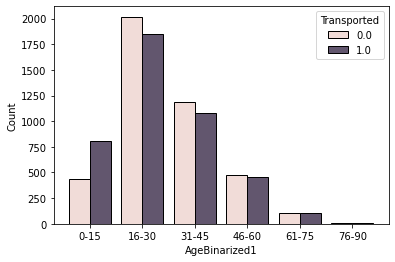

In [69]:
sns.histplot(data, x='AgeBinarized1', hue='Transported', multiple='dodge', shrink=.8);

In [70]:
data['AgeBinarized2'] = pd.cut(data.Age, bins=[-1, 20, 40, 60, 80], labels=["0-20", "20-40", "40-60", "60-80"])
data.AgeBinarized2.value_counts(dropna=False)

20-40    6487
0-20     3652
40-60    2234
60-80     327
NaN       270
Name: AgeBinarized2, dtype: int64

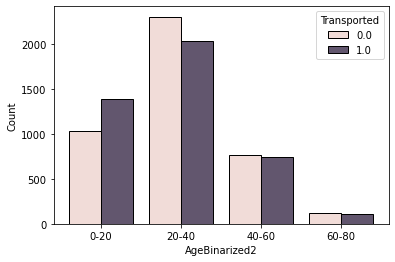

In [71]:
sns.histplot(data, x='AgeBinarized2', hue='Transported', multiple='dodge', shrink=.8);

## VIP

Whether the passenger has paid for special VIP service during the voyage.

In [38]:
data.VIP.value_counts(dropna=False)

False    12401
NaN        296
True       273
Name: VIP, dtype: int64

In [39]:
data['VIP'] = data.VIP.astype('string').fillna('Ns/Nc')

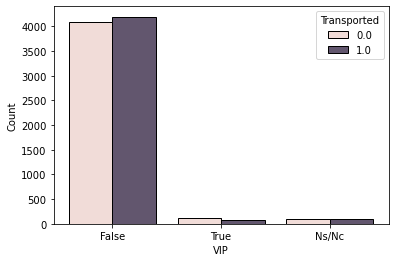

In [40]:
sns.histplot(data, x='VIP', hue='Transported', multiple='dodge', shrink=.8);

Las 2 clases tienen prácticamente la misma representación en clientes VIP y no VIP.

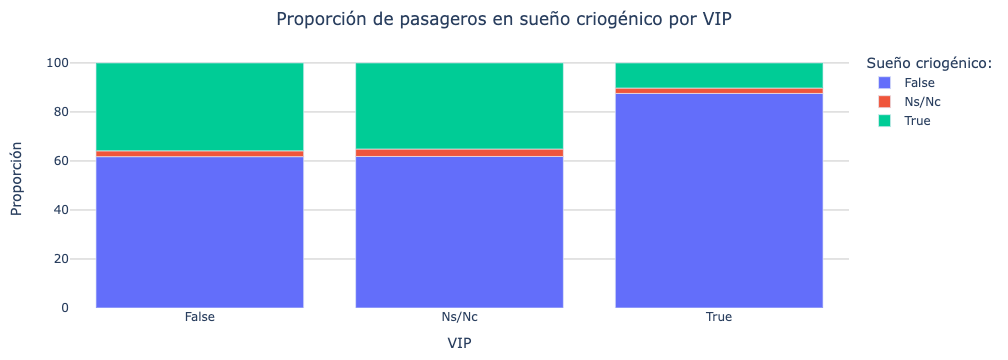

In [64]:
tmp = data.groupby(['CryoSleep','VIP']).count().iloc[:,0]
tmp.name = 'Count'
df = tmp.to_frame().reset_index()
df['Núm. pasajeros'] = df.Count

fig = px.bar(df, x="VIP", y="Count", color="CryoSleep", hover_data={'VIP':False, 'CryoSleep':False, 'Núm. pasajeros':True}, labels={"Count": "Proporción"})
fig.update_layout(plot_bgcolor='white',
                  hovermode="closest",
                  legend={'title_text':'Sueño criogénico:'},
                  title={'text': 'Proporción de pasajeros en sueño criogénico por VIP', 'x': 0.5},
                  margin={'l':70, 'r':140, 't':50, 'b':50},
                  barnorm='percent')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=True, gridwidth=1.2, gridcolor='#d1d1d1')
fig.show()

Entre los pasajeros `VIP` hay una menor proporción de pasajeros en sueño criogénico (`CryoSleep`) que entre los pasajeros no VIP. A pesar de ello, la diferencia no es suficientemente amplia ni el número de pasajeros es suficientemente grande como para asignar un valor a los que no tienen la variable `VIP` informada.

## RoomService & FoodCourt & ShoppingMall & Spa & VRDeck

Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

In [41]:
data[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].describe()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,222.897852,451.961675,174.906033,308.476904,306.789482
std,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,49.000000,77.000000,29.000000,57.000000,42.000000
max,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


Asignar el valor 0 a estas variables cuando no están informadas tiene bastante sentido teniendo en cuenta que la mediana es 0. Una alternativa podría ser ver la correlación que tienen con `Age` por ejemplo, sin embargo esta no supera el 0.12 en ningún caso.

In [42]:
data['TotalExpenses'] = data[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
data.TotalExpenses.describe()

count    12970.000000
mean      1433.221049
std       2807.369708
min          0.000000
25%          0.000000
50%        716.000000
75%       1442.000000
max      35987.000000
Name: TotalExpenses, dtype: float64

In [43]:
data.loc[data.TotalExpenses!=0, 'TotalExpenses'].describe()

count     7513.000000
mean      2474.228271
std       3321.232251
min          1.000000
25%        797.000000
50%       1219.000000
75%       2602.000000
max      35987.000000
Name: TotalExpenses, dtype: float64

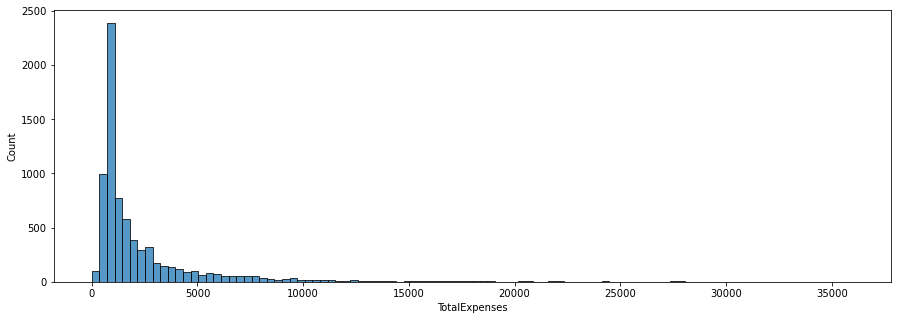

In [44]:
plt.subplots(figsize=(15,5))
sns.histplot(data.loc[data.TotalExpenses!=0, 'TotalExpenses'], bins=100);

In [45]:
quantiles = data.loc[data.TotalExpenses!=0, 'TotalExpenses'].quantile([0.33, 0.66, 0.95]).values
bins = np.append( np.insert(quantiles, 0, [0, 0.5]), np.inf )
data['TotalExpensesBinarized'] = pd.cut(data.TotalExpenses, bins, include_lowest=True, labels=["ZERO","LOW","MEDIUM","HIGH","TOP"])
data.TotalExpensesBinarized.value_counts(dropna=False)

ZERO      5457
LOW       2484
MEDIUM    2475
HIGH      2178
TOP        376
Name: TotalExpensesBinarized, dtype: int64

También se puede hacer esto mismo con los gastos desdoblados.

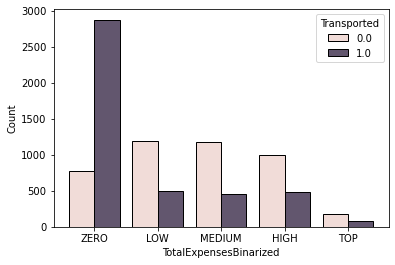

In [46]:
sns.histplot(data, x='TotalExpensesBinarized', hue='Transported', multiple='dodge', shrink=.8);

In [47]:
data.groupby('TotalExpensesBinarized')['CabinDeck'].value_counts(dropna=False)

TotalExpensesBinarized  CabinDeck
ZERO                    G            2500
                        F             995
                        B             683
                        C             501
                        E             340
                        D             177
                        Ns/Nc         136
                        A             125
LOW                     F            1373
                        G             698
                        E             324
                        Ns/Nc          53
                        D              30
                        C               6
MEDIUM                  F            1297
                        G             497
                        E             437
                        D             152
                        Ns/Nc          52
                        A              18
                        B              11
                        C              10
                        T               1


Está claro que los pasajeros con menos recursos no se alojaban en el `CabinDeck` 'G'.

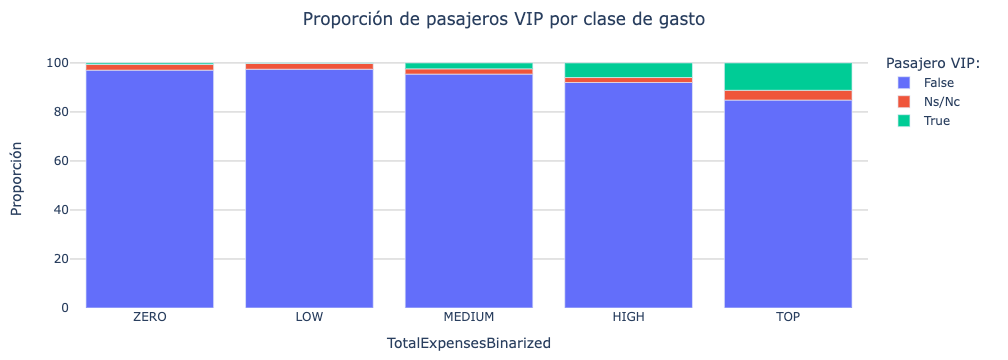

In [73]:
tmp = data.groupby(['TotalExpensesBinarized','VIP']).count().iloc[:,0]
tmp.name = 'Count'
df = tmp.to_frame().reset_index()
df['Núm. pasajeros'] = df.Count

fig = px.bar(df, x="TotalExpensesBinarized", y="Count", color="VIP", hover_data={'VIP':False, 'TotalExpensesBinarized':False, 'Núm. pasajeros':True}, labels={"Count": "Proporción"})
fig.update_layout(plot_bgcolor='white',
                  hovermode="closest",
                  legend={'title_text':'Pasajero VIP:'},
                  title={'text': 'Proporción de pasajeros VIP por clase de gasto', 'x': 0.5},
                  margin={'l':70, 'r':140, 't':50, 'b':50},
                  barnorm='percent')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=True, gridwidth=1.2, gridcolor='#d1d1d1')
fig.show()

La variable `TotalExpensesBinarized` está correlacionada con la variable `VIP`.

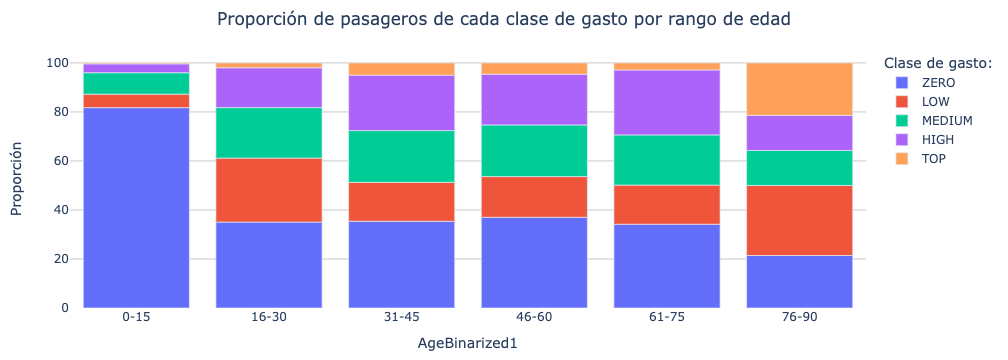

In [72]:
tmp = data.groupby(['TotalExpensesBinarized','AgeBinarized1']).count().iloc[:,0]
tmp.name = 'Count'
df = tmp.to_frame().reset_index()
df['Núm. pasajeros'] = df.Count

fig = px.bar(df, x="AgeBinarized1", y="Count", color="TotalExpensesBinarized", hover_data={'AgeBinarized1':False, 'TotalExpensesBinarized':False, 'Núm. pasajeros':True}, labels={"Count": "Proporción"})
fig.update_layout(plot_bgcolor='white',
                  hovermode="closest",
                  legend={'title_text':'Clase de gasto:'},
                  title={'text': 'Proporción de pasajeros de cada clase de gasto por rango de edad', 'x': 0.5},
                  margin={'l':70, 'r':140, 't':50, 'b':50},
                  barnorm='percent')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=True, gridwidth=1.2, gridcolor='#d1d1d1')
fig.show()

In [49]:
data['Expenses'] = (data.TotalExpenses != 0).astype('str')
data.Expenses.value_counts(dropna=False)

True     7513
False    5457
Name: Expenses, dtype: int64

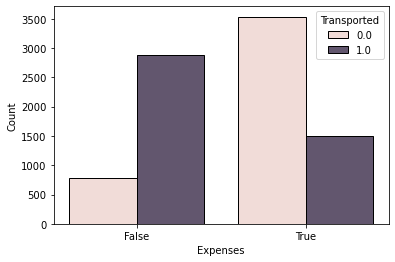

In [50]:
sns.histplot(data, x='Expenses', hue='Transported', multiple='dodge', shrink=.8);

Entre los pasajeros que sí tenían gastos adicionales hay una menor proporción de pasajeros perdidos que entre los que no tenían gastos adicionales. Esto probablemente esté relacionado con el nivel de renta.

## Name

The first and last names of the passenger.

In [51]:
from gender_guesser import detector
d = detector.Detector()

In [52]:
def get_sex(name):
    if pd.notna(name):
        sex = d.get_gender( name.split(' ')[0] )
        return sex if sex in ['female','male'] else 'Ns/Nc'
    else:
        return 'Ns/Nc'

data['Sex'] = data.Name.apply(get_sex)
data.Sex.value_counts(dropna=False)

Ns/Nc     11124
female     1230
male        616
Name: Sex, dtype: int64

In [53]:
data.loc[data.Sex=='male', 'Name'].sample(5)

1144     Erick Pollarkeeks
8962         Royce Yatters
11680      Artis Calhounez
7183        Daley Patthews
3192          Saleh Modent
Name: Name, dtype: object

Hay ejemplos en los que se ve que la clasificación no es completamente precisa, por lo que descartamos extraer el sexo a partir del nombre. Además, en la mayoría de proyectos trabajar con el nombre es poco probable debido a la confidencialidad de los datos.

## Transported

Whether the passenger was transported to another dimension. **This is the target**, the column you are trying to predict.

In [54]:
data.Transported.value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

Las dos clases están igualmente representadas.

---

In [55]:
data.dtypes

PassengerId                 object
HomePlanet                  object
CryoSleep                   string
Cabin                       object
Destination                 string
Age                        float64
VIP                         string
RoomService                float64
FoodCourt                  float64
ShoppingMall               float64
Spa                        float64
VRDeck                     float64
Name                        object
Transported                 object
PassengerGroup              object
PassengerGroupNum           object
GroupSize                   object
CabinDeck                   object
CabinNum                    object
CabinSide                   object
AgeBinarized              category
TotalExpenses              float64
TotalExpensesBinarized    category
Expenses                    object
Sex                         object
dtype: object

In [56]:
data.corr(numeric_only=True).style.background_gradient('viridis')

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalExpenses
Age,1.000000,0.067300,0.124447,0.034959,0.118992,0.101441,0.179890
RoomService,0.067300,1.000000,-0.020146,0.057402,0.008936,-0.023847,0.225418
FoodCourt,0.124447,-0.020146,1.000000,-0.001589,0.228990,0.244279,0.747820
ShoppingMall,0.034959,0.057402,-0.001589,1.000000,0.010504,0.004485,0.229435
Spa,0.118992,0.008936,0.228990,0.010504,1.000000,0.149874,0.593120
VRDeck,0.101441,-0.023847,0.244279,0.004485,0.149874,1.000000,0.605014
TotalExpenses,0.179890,0.225418,0.747820,0.229435,0.593120,0.605014,1.000000
